Logs:
- [2024/04/26]    
  First attempt

In [55]:
import requests
import re
import numpy as np
import matplotlib.pyplot as plt

from typing import List
from bs4 import BeautifulSoup
from scratch.deep_learning import Tensor, Linear, Sequential,\
  SoftmaxCrossEntropy, GradientDescent
from scratch.word2vec import Word2Vec as w2v
from scratch.word2vec import Vocabulary, TextEmbedding
from scratch.working_with_data import DimReduction

In [56]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In [8]:
%load_ext autoreload
%autoreload 2 

An example of `word2vec` for a Wikipedia article

In [9]:
url = "https://en.wikipedia.org/wiki/Actuarial_science"
html = requests.get(url).text
soup = BeautifulSoup(html, "html5lib")

# content = soup.find("div", "bodyContent")
content = soup.find("div", "mw-content-ltr")
regex = r"[\w']+|[\.]"

document = []
for paragraph in content("p"):
  words = re.findall(regex, paragraph.text)
  document.extend(words)

document

['Actuarial',
 'science',
 'is',
 'the',
 'discipline',
 'that',
 'applies',
 'mathematical',
 'and',
 'statistical',
 'methods',
 'to',
 'assess',
 'risk',
 'in',
 'insurance',
 'pension',
 'finance',
 'investment',
 'and',
 'other',
 'industries',
 'and',
 'professions',
 '.',
 'More',
 'generally',
 'actuaries',
 'apply',
 'rigorous',
 'mathematics',
 'to',
 'model',
 'matters',
 'of',
 'uncertainty',
 'and',
 'life',
 'expectancy',
 '.',
 'Actuaries',
 'are',
 'professionals',
 'trained',
 'in',
 'this',
 'discipline',
 '.',
 'In',
 'many',
 'countries',
 'actuaries',
 'must',
 'demonstrate',
 'their',
 'competence',
 'by',
 'passing',
 'a',
 'series',
 'of',
 'rigorous',
 'professional',
 'examinations',
 'focused',
 'in',
 'fields',
 'such',
 'as',
 'probability',
 'and',
 'predictive',
 'analysis',
 '.',
 'Actuarial',
 'science',
 'includes',
 'a',
 'number',
 'of',
 'interrelated',
 'subjects',
 'including',
 'mathematics',
 'probability',
 'theory',
 'statistics',
 'finance',


In [15]:
# Transform document into sentence
sentences = [sentence.strip()+"." for sentence in " ".join(document).split(".")]
sentences

['Actuarial science is the discipline that applies mathematical and statistical methods to assess risk in insurance pension finance investment and other industries and professions.',
 'More generally actuaries apply rigorous mathematics to model matters of uncertainty and life expectancy.',
 'Actuaries are professionals trained in this discipline.',
 'In many countries actuaries must demonstrate their competence by passing a series of rigorous professional examinations focused in fields such as probability and predictive analysis.',
 'Actuarial science includes a number of interrelated subjects including mathematics probability theory statistics finance economics financial accounting and computer science.',
 'Historically actuarial science used deterministic models in the construction of tables and premiums.',
 'The science has gone through revolutionary changes since the 1980s due to the proliferation of high speed computers and the union of stochastic actuarial models with modern fin

### Assembly our training data

In [25]:
# This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]

# Create a vocabulary (that is, a mapping word -> word_id) based on our text
vocab = Vocabulary(word for sentence_words in tokenized_sentences
                          for word in sentence_words)

In [31]:
# [print(sentence) for sentence in (tokenized_sentences[:5])]
# display(vocab)

In [61]:
print(vocab.size)

# unique_word = [vocab.get_word(i) for i in range(vocab.size)]
# display(unique_word)

# display([vocab.get_id(word) for word in unique_word])

# ([print(vocab.one_hot_encode(word)) for word in unique_word]);

743


Create training data

In [33]:
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
  for i, word in enumerate(sentence):       # For each word
    for j in [i - 2, i - 1, i + 1, i + 2]:  # take the nearby locations
      if 0 <= j < len(sentence):            # that aren't out of bounds
        nearby_word = sentence[j]           # and get those words.

        # Add an input that's the original word_id
        inputs.append(vocab.get_id(word))

        # Add a target that's the one-hot-encoded nearby word
        targets.append(vocab.one_hot_encode(nearby_word))

In [49]:
# print(inputs)
# print(len(inputs))
# [print(target) for target in targets];
# print(np.shape(targets))

### Create the model

In [41]:
seed = 2023_05
rng = np.random.default_rng(seed)
EMBEDDING_DIM = 5     # seems like a good size

# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM, rng=rng)

model = Sequential([
  # Given a word (as a vector of word_ids), look up its embedding.backward
  embedding, 
  # And use a linear layer to compute scores for "nearby words."
  Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size, rng=rng)
])

### Train the model

In [48]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

select_three_words = ["actuarial", "data", "science"]

total_epoch = 10    # 380 secs
for epoch in range(total_epoch):
  epoch_loss = 0.0
  for input_, target_ in zip(inputs, targets):
    predicted = model.forward(input_)
    epoch_loss += loss.loss(predicted, target_)
    gradient = loss.gradient(predicted, target_)
    model.backward(gradient)
    optimizer.step(model)

  print(epoch, epoch_loss)            # Print the loss
  print(embedding.closest(select_three_words[0]))   # and also a few nearest words
  print(embedding.closest(select_three_words[1]))    # so we can see what's being
  print(embedding.closest(select_three_words[2]))     # learned

0 40596.94076947624
[(1.0, 'actuarial'), (0.95161874414368, 'discrimination'), (0.9380374977980208, 'overall'), (0.9357996964854111, 'interest'), (0.9222657163983028, 'trend')]
[(1.0, 'data'), (0.9575501392481591, 'search'), (0.9558794333126077, 'pay'), (0.9491089574762062, 'important'), (0.9480919091431779, 'gone')]
[(1.0, 'science'), (0.95293644906904, 'assumptions'), (0.9498651048109887, 'germanic'), (0.9379052093104283, 'under'), (0.934242893905893, 'weather')]
1 40506.02025949929
[(1.0, 'actuarial'), (0.9521354659433586, 'discrimination'), (0.9425057261340616, 'overall'), (0.932005313535442, 'interest'), (0.9230590644875297, 'trend')]
[(1.0, 'data'), (0.9576167781678417, 'search'), (0.9532279706649509, 'pay'), (0.9478867787125436, 'gone'), (0.9474778942537874, 'important')]
[(1.0, 'science'), (0.9520708627300879, 'assumptions'), (0.9515600397852324, 'germanic'), (0.9379992667981636, 'under'), (0.9361822396799071, 'weather')]
2 40418.88740978121
[(1.0, 'actuarial'), (0.951565353447

### Explore the result

In [51]:
pairs = [(w2v.cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
          for w1 in vocab.w2i
            for w2 in vocab.w2i
              if w1 < w2]

pairs.sort(reverse=True)
display(pairs[:5])

[(0.9987716840692574, 'commutation', 'independently'),
 (0.9962500779984752, 'father', 'profession'),
 (0.9959854395279274, 'has', 'returns'),
 (0.9958457569524332, 'adjust', 'employment'),
 (0.9954697474156029, 'probability', 'related')]

In [57]:
components = DimReduction.pca(embedding.embeddings, 2)
transformed = DimReduction.transform(embedding.embeddings, components)

dv: 805.048: 100%|██████████| 100/100 [00:00<00:00, 167.85it/s]


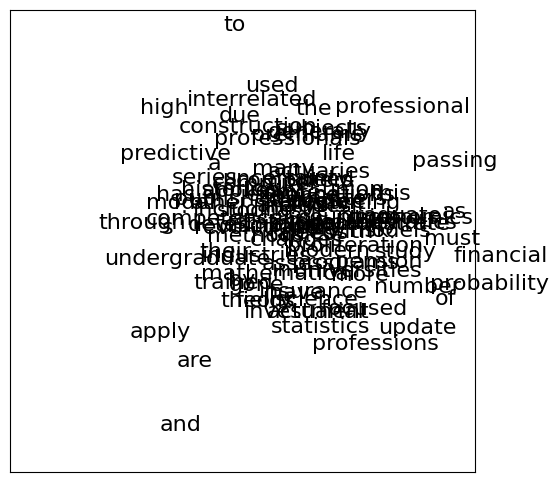

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(*zip(*transformed), marker='.', color='w')

# Add annotations for each word at its transformed location
for idx, (word, idx) in enumerate(vocab.w2i.items()):
  ax.annotate(word, transformed[idx])

  if idx > 100:
    break

# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show(fig)

Because the scratch module is too slow to run for 743 unique words, we move to another jupyter notebook that uses TensorFlow library. See [`word2vec_wiki.ipynb`](./word2vec_wiki_withTF.ipynb)